# Chapter 3.2 - Chapter 3.7

In this notebook, we demonstrate how to construct various neural networks, ranging from the canonical fully connected neural networks to transformers. Note that the focus here is on network architecture, so we will not adjust hyperparameters. We will use a fixed validation set with early stop to control for overfitting problem. In Chapter 4, we demonstrate how to perform cross-valiation to select the most appropriate hyperparameters. 

In [1]:
import os 
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(current_dir)
sys.path.append(project_dir)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt 
from Utilis.early_stopper import EarlyStopping

torch.manual_seed(42)
np.random.seed(42)

In [6]:
def train_model(model, X_train, y_train, X_val, y_val, X_test, 
                savepath, epochs=5, lr=1e-3, batch_size=32, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
    
    early_stopper = EarlyStopping(savepath=savepath, patience=patience, min_delta=1e-4, verbose=True)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)

        epoch_loss /= len(dataloader.dataset)
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss = criterion(y_pred_val, y_val).item()

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train loss: {epoch_loss:.4f}, "
              f"Validation loss: {val_loss:.4f}")
        
        early_stopper(model, val_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break
    
    model.load_state_dict(torch.load(savepath))
    model.eval()
    y_pred_test = model(X_test)    
    return model, y_pred_test

In [3]:
class MLP(nn.Module):
    def __init__(self, seq_length, n_features):
        super(MLP, self).__init__()
        self.flat_dim = seq_length * n_features
        self.net = nn.Sequential(
            nn.Flatten(),                   # (batch, seq_length*n_features)
            nn.Linear(self.flat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)                
        )
    def forward(self, x):
        return self.net(x)

class CNN(nn.Module):
    def __init__(self, n_features, out_channels=32):
        super(CNN, self).__init__()
        # in_channels = n_features, kernel_size=3, padding=1 
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=n_features,
                      out_channels=out_channels,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels,
                      kernel_size=3,
                      padding=1),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool1d(1)  
        self.fc   = nn.Linear(out_channels, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = x.permute(0, 2, 1)  
        x = self.conv(x)
        x = self.pool(x)        # shape: (batch, out_channels, 1)
        x = x.squeeze(-1)       # (batch, out_channels)
        x = self.fc(x)          # (batch,1)
        return x

class WaveNetLike(nn.Module):
    def __init__(self, n_features, out_channels=32,
                 kernel_size=2, dilation_depth=4):
        super(WaveNetLike, self).__init__()
        layers = []
        in_channels = n_features
        for d in range(dilation_depth):
            dilation_rate = 2 ** d
            padding = (kernel_size - 1) * dilation_rate
            conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                dilation=dilation_rate,
                padding=padding
            )
            layers.append(conv)
            in_channels = out_channels

        self.convs = nn.ModuleList(layers)
        self.activation = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Linear(out_channels, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = x.permute(0, 2, 1)  # (batch, n_features, seq_length)

        for conv in self.convs:
            x = conv(x)
            x = self.activation(x)

        x = self.pool(x)        # (batch, out_channels, 1)
        x = x.squeeze(-1)       # (batch, out_channels)
        x = self.fc(x)          # (batch,1)
        return x

class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        # x: (batch, seq_length, n_features)
        output, (h_n, c_n) = self.lstm(x)
        # output: (batch, seq_length, hidden_size)
        last_output = output[:, -1, :]  # (batch, hidden_size)
        return self.fc(last_output)

class TransformerModel(nn.Module):
    def __init__(self, seq_length, n_features, d_model=64, nhead=4, num_layers=2):
        super(TransformerModel, self).__init__()
        self.d_model = d_model

        self.input_fc = nn.Linear(n_features, d_model)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, seq_length, d_model)
        )

        # TransformerEncoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = self.input_fc(x)  # (batch, seq_length, d_model)

        seq_len = x.size(1)
        x = x + self.pos_embedding[:, :seq_len, :]
        x = self.transformer_encoder(x)  # (batch, seq_length, d_model)

        # Global Average Pooling over seq_length
        x = x.permute(0, 2, 1)
        x = self.pool(x)  # (batch, d_model, 1)
        x = x.squeeze(-1) # (batch, d_model)

        x = self.fc(x)    # (batch, 1)
        return x

I here simiulate some data to perform a regression problem. The x inputs have dimension of (batch_samples, time look-back windows, feature numbers).

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
N = 2000           
seq_length = 20    
n_features = 3    

# X: (N, seq_length, n_features)
X_np = np.random.randn(N, seq_length, n_features)
noise = 0.1 * np.random.randn(N)
y_np = 2 * X_np[:, -1, 0] + 3 * X_np[:, -1, 1] - 1.5 * X_np[:, -1, 2] + noise
y_np = y_np.reshape(-1, 1)  # shape (N,1)

split_index_val = int(N * 0.6)
split_index_test = int(N * 0.8)

X_train_np = X_np[:split_index_val]
y_train_np = y_np[:split_index_val]
X_val_np = X_np[split_index_val:split_index_test]
y_val_np = y_np[split_index_val:split_index_test]
X_test_np  = X_np[split_index_test:]
y_test_np  = y_np[split_index_test:]

X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val_np, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32).to(device)

print("Train X shape:", X_train.shape)
print("Train y shape:", y_train.shape)
print("Val X shape:", X_val.shape)
print("Val y shape:", y_val.shape)
print("Test  X shape:", X_test.shape)
print("Test  y shape:", y_test.shape)

Using device: cpu
Train X shape: torch.Size([1200, 20, 3])
Train y shape: torch.Size([1200, 1])
Val X shape: torch.Size([400, 20, 3])
Val y shape: torch.Size([400, 1])
Test  X shape: torch.Size([400, 20, 3])
Test  y shape: torch.Size([400, 1])


In [8]:
mlp_model = MLP(seq_length, n_features).to(device)
mlp_model, y_pred_mlp = train_model(mlp_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='model/best_mlp')

Epoch 1/40, Train loss: 15.7889, Validation loss: 14.0913
Epoch 2/40, Train loss: 13.0180, Validation loss: 9.6333
Validation loss improved. Resetting counter.
Epoch 3/40, Train loss: 5.6120, Validation loss: 2.3532
Validation loss improved. Resetting counter.
Epoch 4/40, Train loss: 0.8513, Validation loss: 0.6105
Validation loss improved. Resetting counter.
Epoch 5/40, Train loss: 0.3712, Validation loss: 0.4812
Validation loss improved. Resetting counter.
Epoch 6/40, Train loss: 0.2487, Validation loss: 0.4101
Validation loss improved. Resetting counter.
Epoch 7/40, Train loss: 0.1756, Validation loss: 0.3699
Validation loss improved. Resetting counter.
Epoch 8/40, Train loss: 0.1341, Validation loss: 0.3352
Validation loss improved. Resetting counter.
Epoch 9/40, Train loss: 0.1041, Validation loss: 0.3159
Validation loss improved. Resetting counter.
Epoch 10/40, Train loss: 0.0819, Validation loss: 0.2913
Validation loss improved. Resetting counter.
Epoch 11/40, Train loss: 0.0682

In [9]:
cnn_model = CNN(n_features=3).to(device)
cnn_model, y_pred_cnn = train_model(cnn_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='model/best_cnn')

Epoch 1/40, Train loss: 16.1513, Validation loss: 15.0724
Epoch 2/40, Train loss: 16.1159, Validation loss: 15.0432
Validation loss improved. Resetting counter.
Epoch 3/40, Train loss: 16.0447, Validation loss: 14.9980
Validation loss improved. Resetting counter.
Epoch 4/40, Train loss: 15.9760, Validation loss: 14.8419
Validation loss improved. Resetting counter.
Epoch 5/40, Train loss: 15.8235, Validation loss: 14.6865
Validation loss improved. Resetting counter.
Epoch 6/40, Train loss: 15.6469, Validation loss: 14.3279
Validation loss improved. Resetting counter.
Epoch 7/40, Train loss: 15.3889, Validation loss: 14.1109
Validation loss improved. Resetting counter.
Epoch 8/40, Train loss: 15.1836, Validation loss: 13.7869
Validation loss improved. Resetting counter.
Epoch 9/40, Train loss: 14.7642, Validation loss: 13.4385
Validation loss improved. Resetting counter.
Epoch 10/40, Train loss: 14.4365, Validation loss: 13.0966
Validation loss improved. Resetting counter.
Epoch 11/40, T

In [10]:
wavenet_model = WaveNetLike(n_features=3).to(device)
wavenet_model, y_pred_wavenet = train_model(wavenet_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='model/best_wavenet')

Epoch 1/40, Train loss: 16.1550, Validation loss: 15.0376
Epoch 2/40, Train loss: 16.0068, Validation loss: 14.7930
Validation loss improved. Resetting counter.
Epoch 3/40, Train loss: 15.5846, Validation loss: 14.0968
Validation loss improved. Resetting counter.
Epoch 4/40, Train loss: 14.7021, Validation loss: 13.0787
Validation loss improved. Resetting counter.
Epoch 5/40, Train loss: 13.7723, Validation loss: 13.1138
No improvement in validation loss. Counter: 1/5
Epoch 6/40, Train loss: 12.6245, Validation loss: 10.4467
Validation loss improved. Resetting counter.
Epoch 7/40, Train loss: 10.3636, Validation loss: 7.5733
Validation loss improved. Resetting counter.
Epoch 8/40, Train loss: 7.4299, Validation loss: 4.4156
Validation loss improved. Resetting counter.
Epoch 9/40, Train loss: 4.8665, Validation loss: 2.8096
Validation loss improved. Resetting counter.
Epoch 10/40, Train loss: 3.0715, Validation loss: 1.9440
Validation loss improved. Resetting counter.
Epoch 11/40, Train

In [11]:
lstm_model = LSTMModel(n_features=3).to(device)
lstm_model, y_pred_lstm = train_model(lstm_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='model/best_lstm')

Epoch 1/40, Train loss: 15.5625, Validation loss: 13.4574
Epoch 2/40, Train loss: 10.4273, Validation loss: 4.3810
Validation loss improved. Resetting counter.
Epoch 3/40, Train loss: 1.5902, Validation loss: 0.1847
Validation loss improved. Resetting counter.
Epoch 4/40, Train loss: 0.1504, Validation loss: 0.0549
Validation loss improved. Resetting counter.
Epoch 5/40, Train loss: 0.0749, Validation loss: 0.0405
Validation loss improved. Resetting counter.
Epoch 6/40, Train loss: 0.0482, Validation loss: 0.0249
Validation loss improved. Resetting counter.
Epoch 7/40, Train loss: 0.0359, Validation loss: 0.0683
No improvement in validation loss. Counter: 1/5
Epoch 8/40, Train loss: 0.0403, Validation loss: 0.0198
Validation loss improved. Resetting counter.
Epoch 9/40, Train loss: 0.0234, Validation loss: 0.0158
Validation loss improved. Resetting counter.
Epoch 10/40, Train loss: 0.0240, Validation loss: 0.0219
No improvement in validation loss. Counter: 1/5
Epoch 11/40, Train loss: 

In [12]:
transformer_model = TransformerModel(seq_length, n_features).to(device)
transformer_model, y_pred_transformer = train_model(transformer_model, X_train, y_train, X_val, y_val, X_test, epochs=40, savepath='model/best_transformer')

Epoch 1/40, Train loss: 11.3343, Validation loss: 2.8292
Epoch 2/40, Train loss: 1.9309, Validation loss: 0.8648
Validation loss improved. Resetting counter.
Epoch 3/40, Train loss: 0.7595, Validation loss: 0.2229
Validation loss improved. Resetting counter.
Epoch 4/40, Train loss: 0.3929, Validation loss: 0.2023
Validation loss improved. Resetting counter.
Epoch 5/40, Train loss: 0.2373, Validation loss: 0.1352
Validation loss improved. Resetting counter.
Epoch 6/40, Train loss: 0.1752, Validation loss: 0.0685
Validation loss improved. Resetting counter.
Epoch 7/40, Train loss: 0.1663, Validation loss: 0.1306
No improvement in validation loss. Counter: 1/5
Epoch 8/40, Train loss: 0.1402, Validation loss: 0.0698
No improvement in validation loss. Counter: 2/5
Epoch 9/40, Train loss: 0.1046, Validation loss: 0.0359
Validation loss improved. Resetting counter.
Epoch 10/40, Train loss: 0.0861, Validation loss: 0.0343
Validation loss improved. Resetting counter.
Epoch 11/40, Train loss: 0.

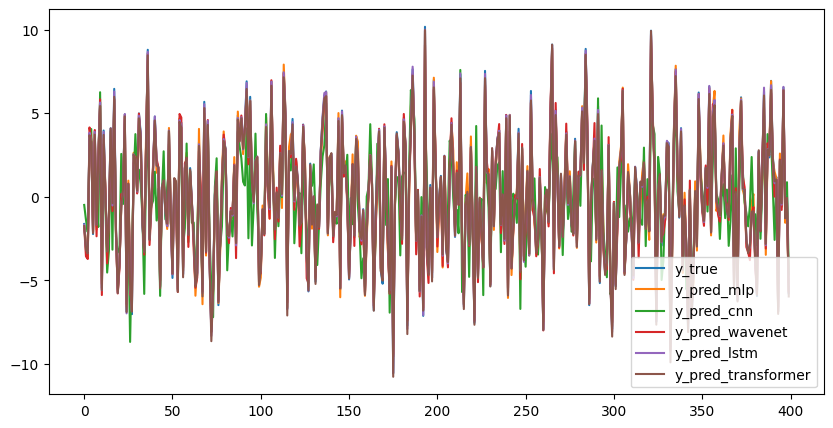

In [13]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='y_true')
plt.plot(y_pred_mlp.detach().numpy(), label='y_pred_mlp')
plt.plot(y_pred_cnn.detach().numpy(), label='y_pred_cnn')
plt.plot(y_pred_wavenet.detach().numpy(), label='y_pred_wavenet')
plt.plot(y_pred_lstm.detach().numpy(), label='y_pred_lstm')
plt.plot(y_pred_transformer.detach().numpy(), label='y_pred_transformer')
plt.legend()